<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/Finalsims_EfficientNetB3_threshcropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filenames = os.listdir("/content/drive/MyDrive/GrayscaleThresholdBeetleImages")
filenames[:4]

['PaperedControl40v.tif',
 'PaperedControl41v.tif',
 'PaperedControl41v_light.tif',
 'PaperedControl41d.tif']

In [4]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 757


In [5]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [6]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [7]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl40v.tif,marked
1,PaperedControl41v.tif,marked
2,PaperedControl41d.tif,marked
3,PaperedControl42v.tif,marked
4,PaperedControl42d.tif,marked
...,...,...
752,PaperedControl38v.tif,marked
753,PaperedControl38d.tif,marked
754,PaperedControl39v.tif,marked
755,PaperedControl39d.tif,marked


In [8]:
df['category'].value_counts()

marked      479
unmarked    278
Name: category, dtype: int64

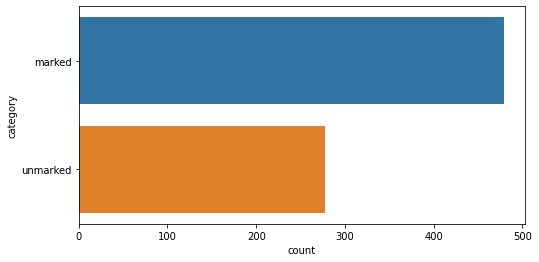

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [10]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", filenames[0]))
image.shape

(1944, 2592, 3)

In [11]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [12]:
tmp_df = df.sample(9)
tmp_df

,filename,category
697,PaperedControl11v.tif,marked
543,NoPaperedMixed49v.tif,unmarked
271,PaperedTransparent97v.tif,marked
202,PaperedTransparent62d.tif,marked
621,PaperedMixed38v.tif,marked
0,PaperedControl40v.tif,marked
574,PaperedMixed14d.tif,marked
682,NoPaperedGreen3v.tif,unmarked
216,PaperedTransparent69d.tif,marked


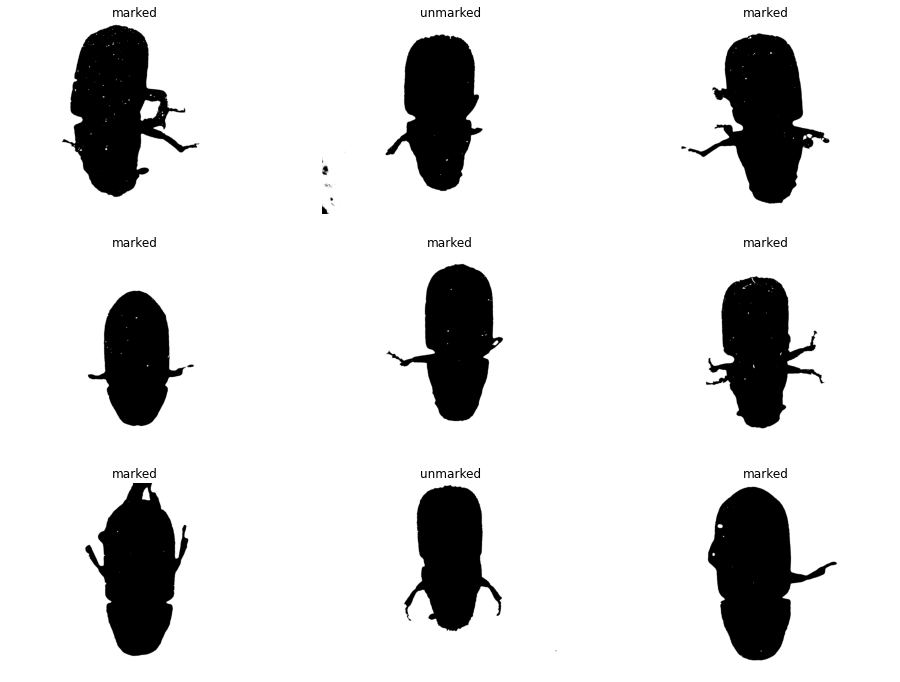

In [13]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [14]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

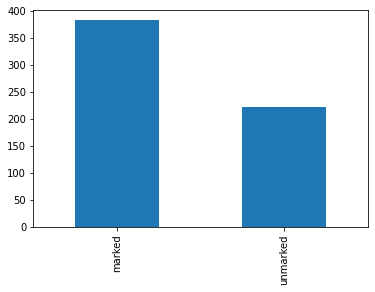

In [15]:
train_df['category'].value_counts().plot.bar()

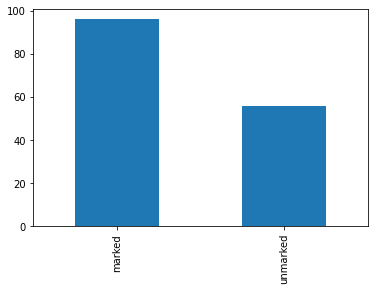

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 50

In [18]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [19]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [20]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 605 validated image filenames belonging to 2 classes.


In [21]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames belonging to 2 classes.


In [22]:
from tensorflow.keras import layers
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [23]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
def create_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

43950080/43941136 [==============================] - 2s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 600, 600, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 600, 600, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPa

In [24]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [25]:
def Model_fit():
    
    model = create_model()
    '''Compiling the model'''
    #unfreeze_model(model)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("B0_original_images_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('/content/drive/MyDrive/finalsims_EB3_threshcropped.h5')  
    return history

In [26]:
results = Model_fit()

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.7225 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


12/12 [==============================] - 710s 63s/step - loss: 0.6770 - accuracy: 0.7225 - val_loss: 0.5257 - val_accuracy: 0.7067 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 746s 62s/step - loss: 0.6288 - accuracy: 0.8252 - val_loss: 0.5202 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 721s 59s/step - loss: 0.5055 - accuracy: 0.8486 - val_loss: 0.4663 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 718s 60s/step - loss: 0.4211 - accuracy: 0.8577 - val_loss: 0.4775 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - ETA: 0s - loss: 0.5719 - accuracy: 0.8342 
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
12/12 [==============================] - 729s 61s/step - loss: 0.5719 - accuracy: 0.8342 - val_loss: 0.4738 - val_accuracy: 0.7067 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 798s 67s/step - los

In [27]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8576576709747314
Val_Cat-Acc:  0.753333330154419


In [28]:
print('Train_Cat-Loss: ', min(results.history['loss']))
print('Val_Cat-Loss: ', min(results.history['val_loss']))

Train_Cat-Loss:  0.4210653007030487
Val_Cat-Loss:  0.4663148522377014


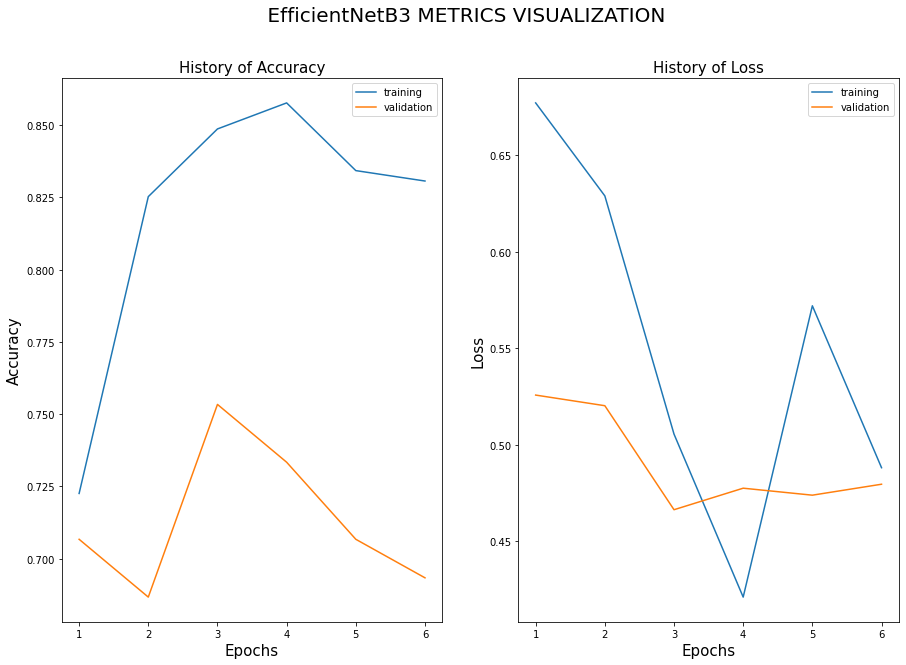

In [29]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" EfficientNetB3 METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [30]:
final_model = keras.models.load_model('/content/drive/MyDrive/finalsims_EB3_threshcropped.h5')

In [31]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
169,PaperedTransparent46v.tif,marked
382,NoPaperedGreen53d.tif,unmarked
389,NoPaperedGreen57v.tif,unmarked
341,NoPaperedGreen17v.tif,unmarked
42,PaperedControl61d.tif,marked
241,PaperedTransparent83v.tif,marked
38,PaperedControl59d.tif,marked
200,PaperedTransparent61d.tif,marked
685,NoPaperedGreen5d.tif,unmarked
483,NoPaperedMixed19v.tif,unmarked


In [32]:
nb_samples = tmp_df1.shape[0]
nb_samples


10

In [33]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator = test_gen.flow_from_dataframe(
    tmp_df1, 
    "/content/drive/MyDrive/GrayscaleThresholdBeetleImages", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10 validated image filenames.


In [34]:
predict = final_model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [35]:
tmp_df1['prediction'] = np.argmax(predict, axis=-1)
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
169,PaperedTransparent46v.tif,marked,marked
382,NoPaperedGreen53d.tif,unmarked,unmarked
389,NoPaperedGreen57v.tif,unmarked,unmarked
341,NoPaperedGreen17v.tif,unmarked,unmarked
42,PaperedControl61d.tif,marked,marked
241,PaperedTransparent83v.tif,marked,marked
38,PaperedControl59d.tif,marked,marked
200,PaperedTransparent61d.tif,marked,unmarked
685,NoPaperedGreen5d.tif,unmarked,unmarked
483,NoPaperedMixed19v.tif,unmarked,marked


In [36]:
to_samples = df.shape[0]

In [37]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/GrayscaleThresholdBeetleImages", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 152 validated image filenames.


In [38]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))

In [39]:
predict

array([[0.37740576, 0.59592974],
       [0.45403972, 0.5085537 ],
       [0.37214303, 0.5108131 ],
       [0.60447395, 0.26401764],
       [0.53379726, 0.545567  ],
       [0.3420361 , 0.5424878 ],
       [0.8408879 , 0.07840461],
       [0.4305984 , 0.53671575],
       [0.43514785, 0.53303164],
       [0.53584623, 0.45192388],
       [0.4100488 , 0.5407956 ],
       [0.6621333 , 0.25813538],
       [0.33027875, 0.6648186 ],
       [0.60766155, 0.3055153 ],
       [0.41304907, 0.31775075],
       [0.6524725 , 0.34624106],
       [0.5875861 , 0.4026956 ],
       [0.88477576, 0.06467292],
       [0.7014696 , 0.309931  ],
       [0.4567763 , 0.4945736 ],
       [0.454451  , 0.27525073],
       [0.84191346, 0.1557821 ],
       [0.6347738 , 0.2586992 ],
       [0.89063   , 0.1194602 ],
       [0.33817658, 0.5245955 ],
       [0.81744885, 0.14574838],
       [0.7575346 , 0.14645407],
       [0.47771573, 0.5290007 ],
       [0.83248556, 0.11744058],
       [0.6262129 , 0.1827653 ],
       [0.

In [40]:
validate_df['prediction'] = np.argmax(predict, axis=-1)
validate_df["prediction"] = validate_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,prediction
0,PaperedControl65d.tif,marked,unmarked
1,NoPaperedMixed38v.tif,unmarked,unmarked
2,NoPaperedGreen43v.tif,unmarked,unmarked
3,NoPaperedMixed7v.tif,unmarked,marked
4,PaperedTransparent28d.tif,marked,unmarked
...,...,...,...
147,PaperedMixed9v.tif,marked,marked
148,NoPaperedGreen61v.tif,unmarked,unmarked
149,NoPaperedGreen57d.tif,unmarked,unmarked
150,PaperedTransparent5d.tif,marked,marked


In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

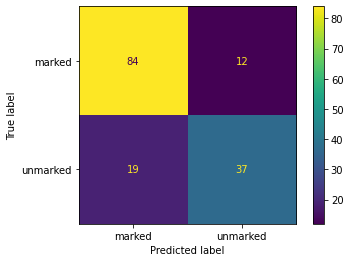

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d") 

In [43]:
validation_accuracy=(cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,0]+cm[0,1]+cm[1,1])
validation_accuracy


0.7960526315789473